In [1]:
import torch
import torch.nn as nn 
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
import copy 

from models import *
from utils import *

# Importing CIFAR-10 

In [3]:
MEANS = (0.5, 0.5, 0.5)
STDS = (0.5, 0.5, 0.5)
BATCH_SIZE = 4
IMG_SIZE = (128, 128)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMG_SIZE),
    transforms.Normalize(MEANS, STDS)
    ])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2
    )

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
    )

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=2
    )

classes = (
    'plane', 'car', 'bird', 'cat', 'deer', 
    'dog', 'frog', 'horse', 'ship', 'truck'
    )

Files already downloaded and verified
Files already downloaded and verified


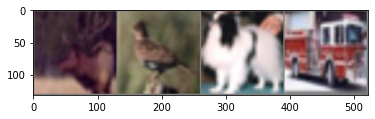

 deer  bird   dog truck


In [4]:
def imshow(img):
    # unnormalize
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))

In [5]:
print(images.shape, labels.shape)

torch.Size([4, 3, 128, 128]) torch.Size([4])


# D-CONV and S-CONV

**NOTE 1** - with proper padding, they're all good

**NOTE 2** - passed the sanity check from tables 3 and 4


In [6]:
ALPHA = 1
NUM_CLASSES = 10
IN_CHANNELS = 3

d_conv = DConv(IN_CHANNELS, ALPHA, IMG_SIZE, num_classes=NUM_CLASSES)
s_conv = SConv(IN_CHANNELS, ALPHA, IMG_SIZE, num_classes=NUM_CLASSES)


In [7]:
out_d = d_conv(images)
out_s = s_conv(images)

print(out_d.shape)
print(out_s.shape)


torch.Size([4, 10])
torch.Size([4, 10])


## Padding discussion


In [8]:
print('Without padding - NO MATCH \n')
print(get_true_parameters_count('D-CONV', ALPHA, IMG_SIZE, NUM_CLASSES))
print(count_parameters(d_conv), '\n')

print(get_true_parameters_count('S-CONV', ALPHA, IMG_SIZE, NUM_CLASSES))
print(count_parameters(s_conv), '\n')

print('Padding: D-1, S-4 - MATCH \n')
d_conv = DConv(IN_CHANNELS, ALPHA, IMG_SIZE, num_classes=NUM_CLASSES, padding=1)
s_conv = SConv(IN_CHANNELS, ALPHA, IMG_SIZE, num_classes=NUM_CLASSES, padding=4)

print(get_true_parameters_count('D-CONV', ALPHA, IMG_SIZE, NUM_CLASSES))
print(count_parameters(d_conv), '\n')

print(get_true_parameters_count('S-CONV', ALPHA, IMG_SIZE, NUM_CLASSES))
print(count_parameters(s_conv), '\n')


Without padding - NO MATCH 

68507
28553 

98787
86883 

Padding: D-1, S-4 - MATCH 

68507
68489 

98787
98787 



# D-FC and S-FC

**NOTE 1** - Should be correct

**NOTE 2** - passed the sanity check from tables 3 and 4


In [9]:
s_fc = SFC(IN_CHANNELS, ALPHA, IMG_SIZE, NUM_CLASSES)
d_fc = DFC(IN_CHANNELS, ALPHA, IMG_SIZE, NUM_CLASSES)

out_fc_d = d_fc(images)
out_fc_s = s_fc(images)

print(out_fc_d.shape)
print(out_fc_s.shape)

Without padding - NO MATCH 

68507
68489 

98787
98787 

Padding: D-1, S-4 - MATCH 

68507
68489 

98787
98787 



# D-LOCAL and S-LOCAL

**NOTE** - Locally connected networks are not implemented in pytorch, 
so we have to implement them ourselves. Again, check if this makes sense, 
I found this implementation by ptrblck on torch hub, to me it makes sense, 
**but** the parameters don't match for the D-LOCAL case.

However, I don't agree with Tables 3 and 4 about the number of parameters for 
D-LOCAL! I think there's a mistake there.

In [10]:
s_local = SLocal(IN_CHANNELS, ALPHA, IMG_SIZE, num_classes=NUM_CLASSES, padding=4)
d_local = DLocal(IN_CHANNELS, ALPHA, IMG_SIZE, num_classes=NUM_CLASSES, padding=1)

print(s_local(images).shape)
print(d_local(images).shape)

torch.Size([4, 10])
torch.Size([4, 10])


## Parameter count


In [11]:
print(get_true_parameters_count('S-LOCAL', ALPHA, IMG_SIZE, NUM_CLASSES))
print(count_parameters(s_local), '\n')

print(get_true_parameters_count('D-LOCAL', ALPHA, IMG_SIZE, NUM_CLASSES))
print(count_parameters(d_local))

1093872.0
1093872 

656000
1245824


## Recreating Table 3 and Table 4, row 2


In [12]:
s_square = IMG_SIZE[0]**2

cnt = count_parameters(d_local.local_layers[0].layers)
print(f'9 x {cnt // 9 // ALPHA // s_square} x {IMG_SIZE[0]}^2 x {ALPHA}')

for i in range(1, len(d_local.local_layers)):
    cnt = count_parameters(d_local.local_layers[i].layers)
    # print(d_local.local_layers[i].layers[0].weight.shape)
    # print(cnt)
    print(f'9 x {IMG_SIZE[0]}^2 x {ALPHA}^2 / {9 * s_square // cnt // ALPHA**2}')

cnt = count_parameters(d_local.fc_layers[0])
print(f'4 x {int((cnt // 4 // ALPHA**2) ** 0.5)}^2 x {ALPHA**2}')

cnt = count_parameters(d_local.fc_layers[1])
print(f'{cnt // ALPHA // NUM_CLASSES} x {NUM_CLASSES} x {ALPHA}')

9 x 3 x 128^2 x 1
9 x 128^2 x 1^2 / 2
9 x 128^2 x 1^2 / 1
9 x 128^2 x 1^2 / 2
9 x 128^2 x 1^2 / 1
9 x 128^2 x 1^2 / 2
9 x 128^2 x 1^2 / 1
9 x 128^2 x 1^2 / 2
4 x 128^2 x 1
64 x 10 x 1


## IMPLEMENTATION OF 3-FC - IN PROGRESS !!!

**NOTE** - I got stuck with this one because there's very little info about it

Please check this one in the paper thoroughly and we'll discuss it

# Results

In [76]:
os.listdir('../checkpoints')

['s-conv_beta_0.0_lr_0.1_lambda_0.0_ep_20',
 's-fc_beta_0.0_lr_0.1_lambda_2e-05_ep_400',
 's-fc_beta_0.0_lr_0.1_lambda_0.0_ep_400',
 's-fc_beta_1.0_lr_0.1_lambda_2e-05_ep_400',
 's-fc_beta_50.0_lr_0.1_lambda_2e-05_ep_400']

In [85]:
sgd = torch.load(
    '../checkpoints/s-fc_beta_0.0_lr_0.1_lambda_0.0_ep_400/sfc_checkpoint.pt',
    map_location=torch.device('cpu')
    )

beta_1 = torch.load(
    '../checkpoints/s-fc_beta_1.0_lr_0.1_lambda_2e-05_ep_400/sfc_checkpoint.pt',
    map_location=torch.device('cpu')
    )

beta_50 = torch.load(
    '../checkpoints/s-fc_beta_50.0_lr_0.1_lambda_2e-05_ep_400/sfc_checkpoint.pt',
    map_location=torch.device('cpu')
    )

sconv_sgd = torch.load(
    '../checkpoints/s-conv_beta_0.0_lr_0.1_lambda_0.0_ep_20/sconv_checkpoint.pt',
    map_location=torch.device('cpu')
    )

slocal_sgd = torch.load(
    '../checkpoints/s-local_beta_0.0_lr_0.1_scheduler_lambda_0.0_ep_20/slocal_checkpoint.pt',
    map_location=torch.device('cpu')
    )


In [63]:
def plot_filters(batch_filters, abs=False):

    fig, axs = plt.subplots(ncols=5, figsize=(5*10, 10))

    for batch_ind in range(5): # range(batch_filters.shape[0]):
        filter = batch_filters[batch_ind]
        
        if abs:
            filter = filter.abs()
        filter = (filter - filter.min()) / (filter.max() - filter.min())
        filter_reshaped = filter.view(3, 32, 32)

        # plt.imshow(filter_reshaped.permute(1, 2, 0).numpy())
        axs[batch_ind].imshow(filter_reshaped.permute(1, 2, 0).numpy())
    plt.show()



In [70]:
beta_50['model_state_dict']['fc_layers.0.layers.0.weight'].shape
beta_50['model_state_dict']['fc_layers.1.0.layers.0.weight'].shape

torch.Size([24, 256])

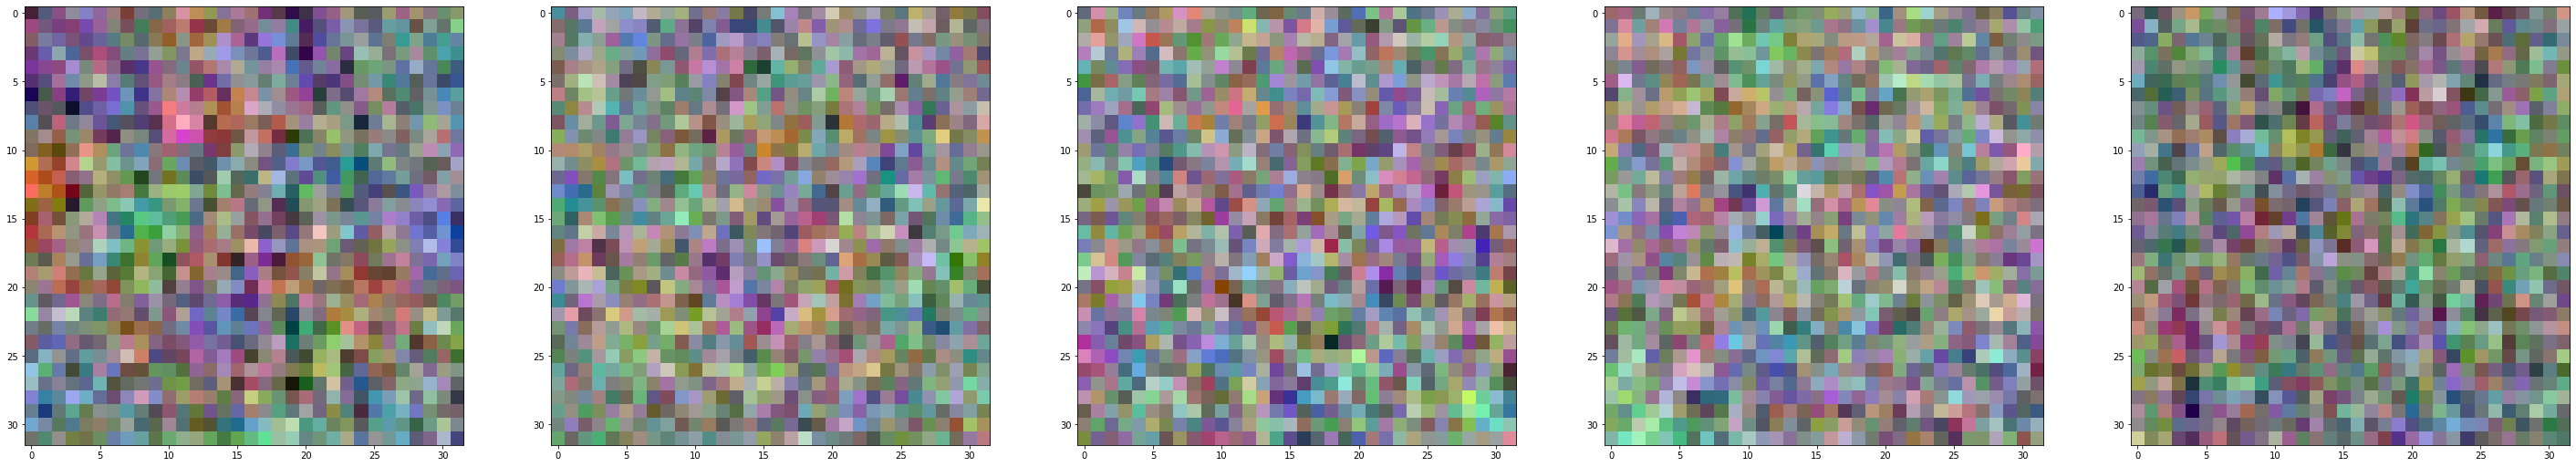

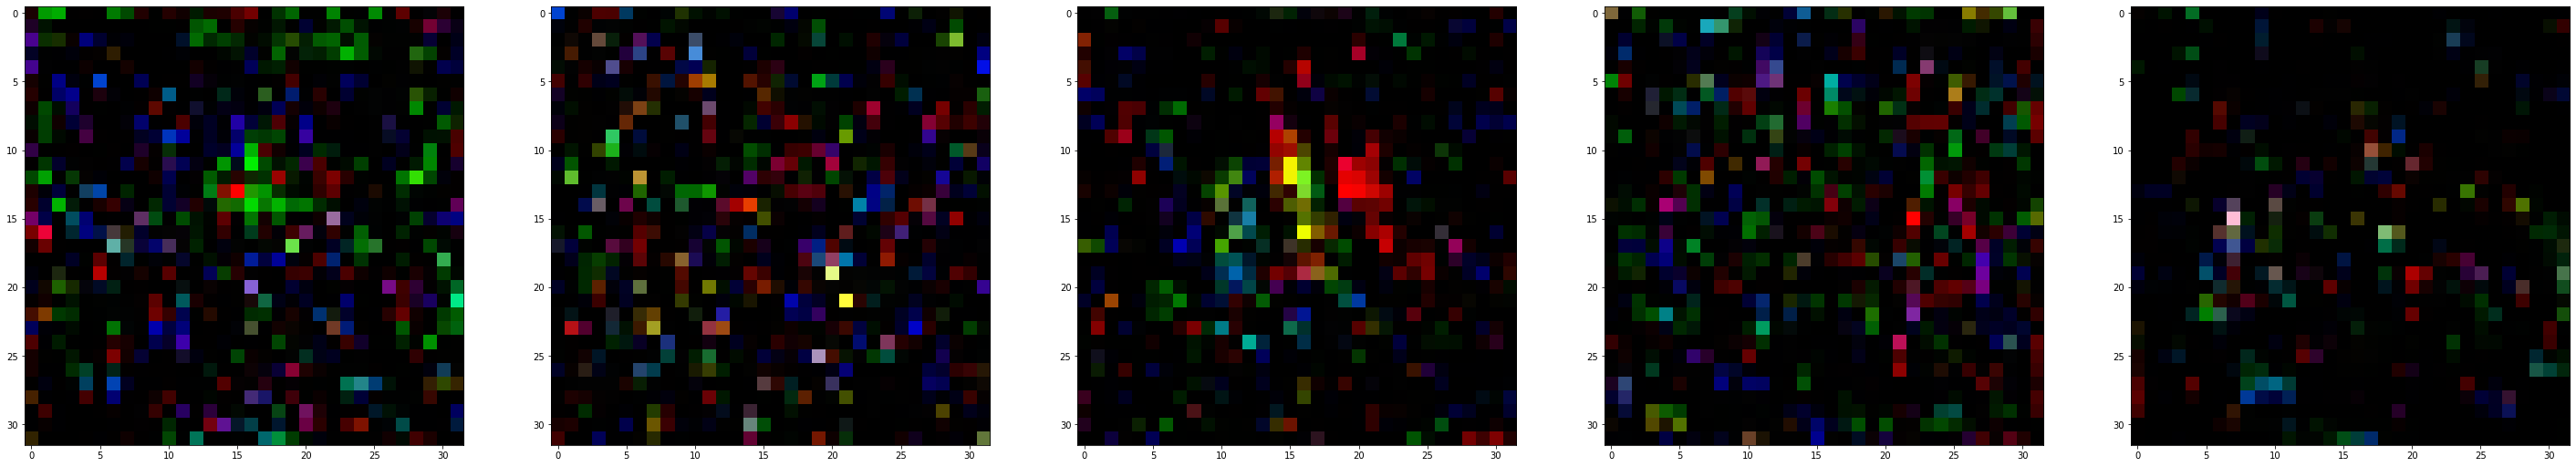

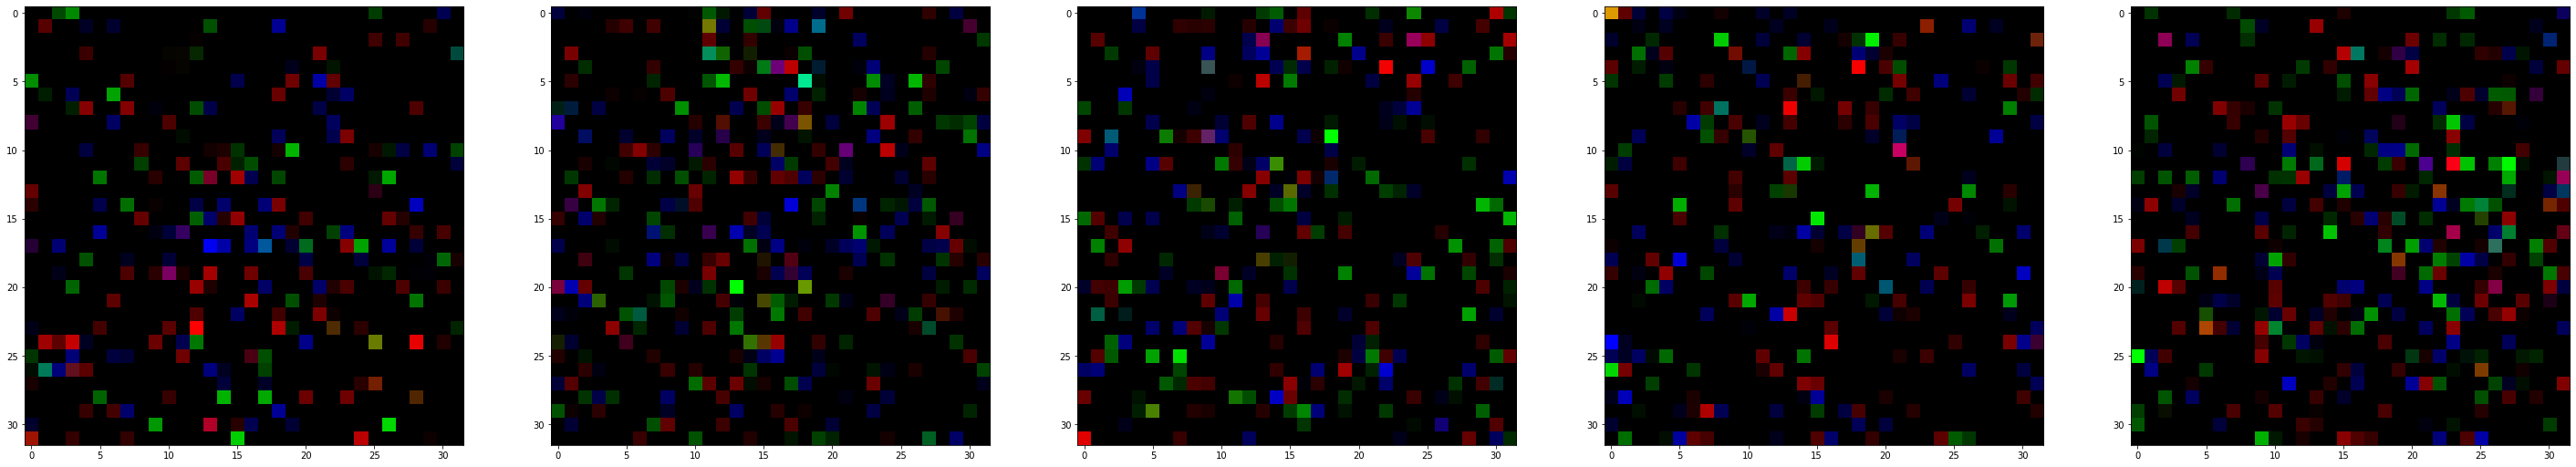

In [68]:
plot_filters(sgd['model_state_dict']['fc_layers.0.layers.0.weight'])
plot_filters(beta_1['model_state_dict']['fc_layers.0.layers.0.weight'], True)
plot_filters(beta_50['model_state_dict']['fc_layers.0.layers.0.weight'], True)



In [104]:
def calc_coords_in(i, j, kernel_size=9, stride=2):
    return (i*stride + int(kernel_size/2), j*stride + int(kernel_size/2))
    
def plot_local_filter(batch_filters, coords_out):
    coords_in = calc_coords_in(coords_out[0], coords_out[1])

    filter = batch_filters[0, 0, : , coords_out[0], coords_out[1], : ]
    filter = filter.view(3, 9, 9).permute(1, 2, 0)

    filter_img = torch.zeros(32, 32, 3)

    filter_img[
        coords_in[0]-int(9/2) : coords_in[0]+int(9/2)+1, 
        coords_in[1]-int(9/2) : coords_in[1]+int(9/2)+1, 
        : 
        ] = filter 

    plt.imshow(filter_img)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


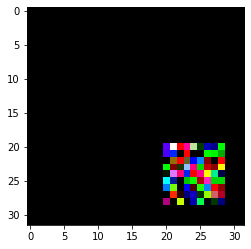

In [106]:
coords_out = (10, 10)

plot_local_filter(
    slocal_sgd['model_state_dict']['local_layer.layers.0.weight'],
    coords_out 
    )


In [4]:
import scipy 

(train_loader, test_loader), num_classes = load_datasets(
    dataset_str='svhn', batch_size=256, num_workers=0
    )


Using downloaded and verified file: ../data/svhn/train_32x32.mat


5.3%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

11.2%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

14.7%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

21.0%IOPub 

In [14]:
sgd = torch.load(
    '../checkpoints/s-fc_beta_0.0_lr_0.1_lambda_0.0_ep_400/sfc_checkpoint.pt',
    map_location=torch.device('cpu')
    )

beta_1 = torch.load(
    '../checkpoints/s-fc_beta_1.0_lr_0.1_lambda_2e-05_ep_400/sfc_checkpoint.pt',
    map_location=torch.device('cpu')
    )

beta_50 = torch.load(
    '../checkpoints/s-fc_beta_50.0_lr_0.1_lambda_2e-05_ep_400/sfc_checkpoint.pt',
    map_location=torch.device('cpu')
    )
    

In [10]:
sgd['model_state_dict'].keys()

odict_keys(['fc_layers.0.layers.0.weight', 'fc_layers.0.layers.1.running_mean', 'fc_layers.0.layers.1.running_var', 'fc_layers.0.layers.1.num_batches_tracked', 'fc_layers.1.0.layers.0.weight', 'fc_layers.1.0.layers.1.running_mean', 'fc_layers.1.0.layers.1.running_var', 'fc_layers.1.0.layers.1.num_batches_tracked', 'fc_layers.1.1.weight'])

In [17]:
layer_str = 'fc_layers.0.layers.0.weight'

print((sgd['model_state_dict'][layer_str] == 0).sum())

print((beta_1['model_state_dict'][layer_str] == 0).sum())

print((beta_50['model_state_dict'][layer_str] == 0).sum())


tensor(0)
tensor(33960)
tensor(714695)


In [18]:
layer_str = 'fc_layers.1.0.layers.0.weight'

print((sgd['model_state_dict'][layer_str] == 0).sum())

print((beta_1['model_state_dict'][layer_str] == 0).sum())

print((beta_50['model_state_dict'][layer_str] == 0).sum())

tensor(0)
tensor(8)
tensor(1548)


In [19]:
layer_str = 'fc_layers.1.1.weight'

print((sgd['model_state_dict'][layer_str] == 0).sum())

print((beta_1['model_state_dict'][layer_str] == 0).sum())

print((beta_50['model_state_dict'][layer_str] == 0).sum())

tensor(0)
tensor(0)
tensor(56)
